# Feature importances

In this notebook we generate the feature importance results shown in Table 6.

In [1]:
%matplotlib inline
import sys
import os
import time

import pandas as pd
import numpy as np

import CBECSLib
CBECSLib = reload(CBECSLib)

import itertools
from collections import defaultdict, Counter

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

#sklearn base
import sklearn.base

#sklearn utility
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

#sklearn models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

#IPython utilities
from IPython.display import HTML,display
def show(html):
    display(HTML(html))

In [2]:
DATASET = 0

In [3]:
pbaLabels = CBECSLib.pbaLabels
pbaPlusLabels = CBECSLib.pbaPlusLabels

getDataset = CBECSLib.getDataset
getClassFrequencies = CBECSLib.getClassFrequencies
getDataSubset = CBECSLib.getDataSubset

# Print extended features

In [4]:
dataKey = {}
f = open("data/cbecs/2012_microdata_codebook.csv","r")
for line in f:
    key,value = map(str.strip,line.split("|"))
    if key!="":
        dataKey[key]=value
f.close()

In [5]:
X,Y,columnNames,classVals = getDataset(0,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

20 classes


In [6]:
for columnName in columnNames:
    if columnName in dataKey:
        print "%s,%s" % (columnName, dataKey[columnName])
    else:
        print columnName

FREESTN,Freestanding building
SQFT,Square footage
SQFTC,Square footage category
WLCNS,Wall construction material
RFCNS,Roof construction material
RFCOOL,Cool roof materials
RFTILT,Roof tilt
BLDSHP,Building shape
GLSSPC,Percent exterior glass
EQGLSS,Equal glass on all sides
NFLOOR,Number of floors
FLCEILHT,Floor to ceiling height
ATTIC,Attic
YRCON,Year of construction
YRCONC,Year of construction category
RENOV,Any renovations
RENADD,Addition or annex
RENRDC,Reduction of floorspace
RENCOS,Cosmetic improvements
RENINT,Interior wall re-configuration
RENRFF,Roof replacement
RENWLL,Exterior wall replacement
RENWIN,Window replacement
RENHVC,HVAC equipment upgrade
RENLGT,Lighting upgrade
RENPLB,Plumbing system upgrade
RENELC,Electrical upgrade
RENINS,Insulation upgrade
RENSAF,Fire, safety, or security upgrade
RENSTR,Structural upgrade
RENOTH,Other renovation
ONEACT,One activity in building
FACIL,On a multibuilding complex
GOVOWN,Government owned
OWNTYPE,Building owner
NOCC,Number of businesses

# Visualize Decision Tree

In [7]:
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image  

In [8]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_all_scaled = scaler.transform(X)


regressor = DecisionTreeRegressor()
regressor.fit(X_train,Y_train)

print "Training r2: ",r2_score(Y_train, regressor.predict(X_train))
print "Testing r2: ",r2_score(Y_test, regressor.predict(X_test))

20 classes
Training r2:  0.999999999556
Testing r2:  0.769596624386


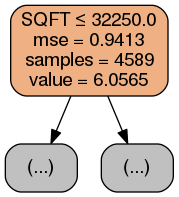

In [9]:
dot_data = export_graphviz(regressor, out_file=None, max_depth=0, feature_names=columnNames, filled=True, rounded=True, special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

# Important Features

In [10]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_all_scaled = scaler.transform(X)

regressor = GradientBoostingRegressor()
regressor.fit(X_train,Y_train)

print "Training r2: ",r2_score(Y_train, regressor.predict(X_train))
print "Testing r2: ",r2_score(Y_test, regressor.predict(X_test))

20 classes
Training r2:  0.918407588475
Testing r2:  0.883681277194


In [11]:
importances = regressor.feature_importances_

assert abs(np.sum(importances)-1) < 1e-5

k = 10
sortedImportancesWithIndices = sorted([(_,i) for i,_ in enumerate(importances)], reverse=True)

for i, (importance, index) in enumerate(sortedImportancesWithIndices[:k]):
    
    description = ""
    if columnNames[index] in dataKey:
        description = dataKey[columnNames[index]]
    else:
        description = columnNames[index]
    
    print "%02d\t%s\t%0.4f\t%s" % (i+1, columnNames[index], importance, description)

01	SQFT	0.1529	Square footage
02	NWKER	0.0841	Number of employees
03	WKHRS	0.0419	Total hours open per week
04	MONUSE	0.0334	Months in use
05	ZMFBTU	0.0320	Imputed major fuels consumption
06	NGUSED	0.0315	Natural gas used
07	CDD65	0.0293	Cooling degree days (base 65)
08	HEATP	0.0256	Percent heated
09	HDD65	0.0252	Heating degree days (base 65)
10	LTOHRP	0.0227	Percent lit when open


# Important features within PBA

In [12]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)


classOutputs = []

for i,classVal in enumerate(classOrdering):
    
    className = pbaLabels[classVal]
    numberOfSamples = classFrequencies[classVal]
    
    #if className!="Food service":
    #    continue
    
    startTime = float(time.time())
    print "%02d/%d\tRunning experiments for %s(n=%d)" % (i+1,len(classOrdering), className, numberOfSamples)
    print "-"*40
    X_temp, Y_temp, classVals_temp = CBECSLib.getDataSubsetWithClassvals(X,Y,classVals,classVal)
    
    rs = StratifiedShuffleSplit(n_splits=1, train_size=0.9, test_size=.1, random_state=0)
    train_index, test_index = next(rs.split(Y_temp,classVals_temp))

    X_train, X_test = X_temp[train_index], X_temp[test_index]
    Y_train, Y_test = Y_temp[train_index], Y_temp[test_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)    
    
    regressor = GradientBoostingRegressor()
    regressor.fit(X_train_scaled,Y_train)
    
    print "Training r2: ",r2_score(Y_train, regressor.predict(X_train_scaled))
    print "Testing r2: ",r2_score(Y_test, regressor.predict(X_test_scaled))

    print "-"*40
    print "-"*40
    
    importances = regressor.feature_importances_

    k = 15
    sortedImportancesWithIndices = sorted([(_,i) for i,_ in enumerate(importances)], reverse=True)

    for i, (importance, index) in enumerate(sortedImportancesWithIndices[:k]):
        description = ""
        if columnNames[index] in dataKey:
            description = dataKey[columnNames[index]]
        else:
            description = columnNames[index]
        print "%02d\t%s\t%0.4f\t%s" % (i+1, columnNames[index], importance, description)
    
    
    print "Finished experiments in %0.4f seconds" % (time.time()-startTime)
    print "-"*40
    print "-"*40
    print ""

20 classes
01/20	Running experiments for Office(n=1044)
----------------------------------------
Training r2:  0.963112044929
Testing r2:  0.926675584529
----------------------------------------
----------------------------------------
01	SQFT	0.1784	Square footage
02	NWKER	0.0686	Number of employees
03	HDD65	0.0397	Heating degree days (base 65)
04	YRCON	0.0324	Year of construction
05	WKHRS	0.0272	Total hours open per week
06	CDD65	0.0247	Cooling degree days (base 65)
07	PCTERMN	0.0216	Number of computers
08	FLUORP	0.0215	Percent lit by fluorescent
09	NGUSED	0.0207	Natural gas used
10	HEATP	0.0183	Percent heated
11	ZMFBTU	0.0173	Imputed major fuels consumption
12	LTOHRP	0.0171	Percent lit when open
13	MAINHT	0.0162	Main heating equipment
14	NFLOOR	0.0161	Number of floors
15	LAPTPN	0.0161	Number of laptops
Finished experiments in 0.4562 seconds
----------------------------------------
----------------------------------------

02/20	Running experiments for Education(n=580)
--------------

Training r2:  0.993174403612
Testing r2:  0.842118973651
----------------------------------------
----------------------------------------
01	SQFT	0.1511	Square footage
02	NWKER	0.0623	Number of employees
03	CDD65	0.0427	Cooling degree days (base 65)
04	PRNTRN	0.0419	Number of printers
05	HDD65	0.0324	Heating degree days (base 65)
06	RENWLL	0.0271	Exterior wall replacement
07	LAPTPN	0.0265	Number of laptops
08	PCTERMN	0.0262	Number of computers
09	NFLOOR	0.0232	Number of floors
10	FLCEILHT	0.0220	Floor to ceiling height
11	PRNTYP	0.0218	Type of printers
12	YRCON	0.0213	Year of construction
13	LTOHRP	0.0208	Percent lit when open
14	COOLP	0.0202	Percent cooled
15	FLATC	0.0190	Flat screen category
Finished experiments in 0.1070 seconds
----------------------------------------
----------------------------------------

12/20	Running experiments for Outpatient health care(n=131)
----------------------------------------
Training r2:  0.998222926417
Testing r2:  0.894816030248
----------------